# Imports

In [5]:
pip install aiohttp

     |████████████████████████████████| 645kB 581kB/s eta 0:00:01
     |████████████████████████████████| 51kB 9.1MB/s  eta 0:00:01
     |████████████████████████████████| 133kB 13.9MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, precision_score, recall_score
import numpy as np
import itertools
import matplotlib.pyplot as plt
import asyncio
import json
import sqlite3
from sqlite3 import Error
from contextlib import contextmanager
from sqlalchemy import create_engine
import pandas as pd

In [28]:
import seaborn as sns

In [3]:
import numpy as np
import sys
import os
import json
import pandas as pd
from collections import Counter
import requests
from IPython.core.display import display, HTML
import lightgbm as lgb
import sklearn
import aiohttp
import asyncio
from sklearn import preprocessing
# from utils import (split_train_test, classification_metrics_binary, classification_metrics_binary_prob,
#                    binarize_prediction, plot_confusion_matrix, run_load_test, read_from_sqlite)
# from utils import BASELINE_MODEL, PORT, TABLE_FRAUD, TABLE_LOCATIONS, DATABASE_FILE

print("System version: {}".format(sys.version))
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("LightGBM version: {}".format(lgb.__version__))
print("Sklearn version: {}".format(sklearn.__version__))

%load_ext autoreload
%autoreload 2

System version: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.18.1
Pandas version: 0.25.1
LightGBM version: 2.3.0
Sklearn version: 0.21.3


/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [90]:
df = pd.read_csv('creditcard.csv')


In [8]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [91]:
df.shape

(284807, 31)

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [172]:
df.shape

(284807, 31)

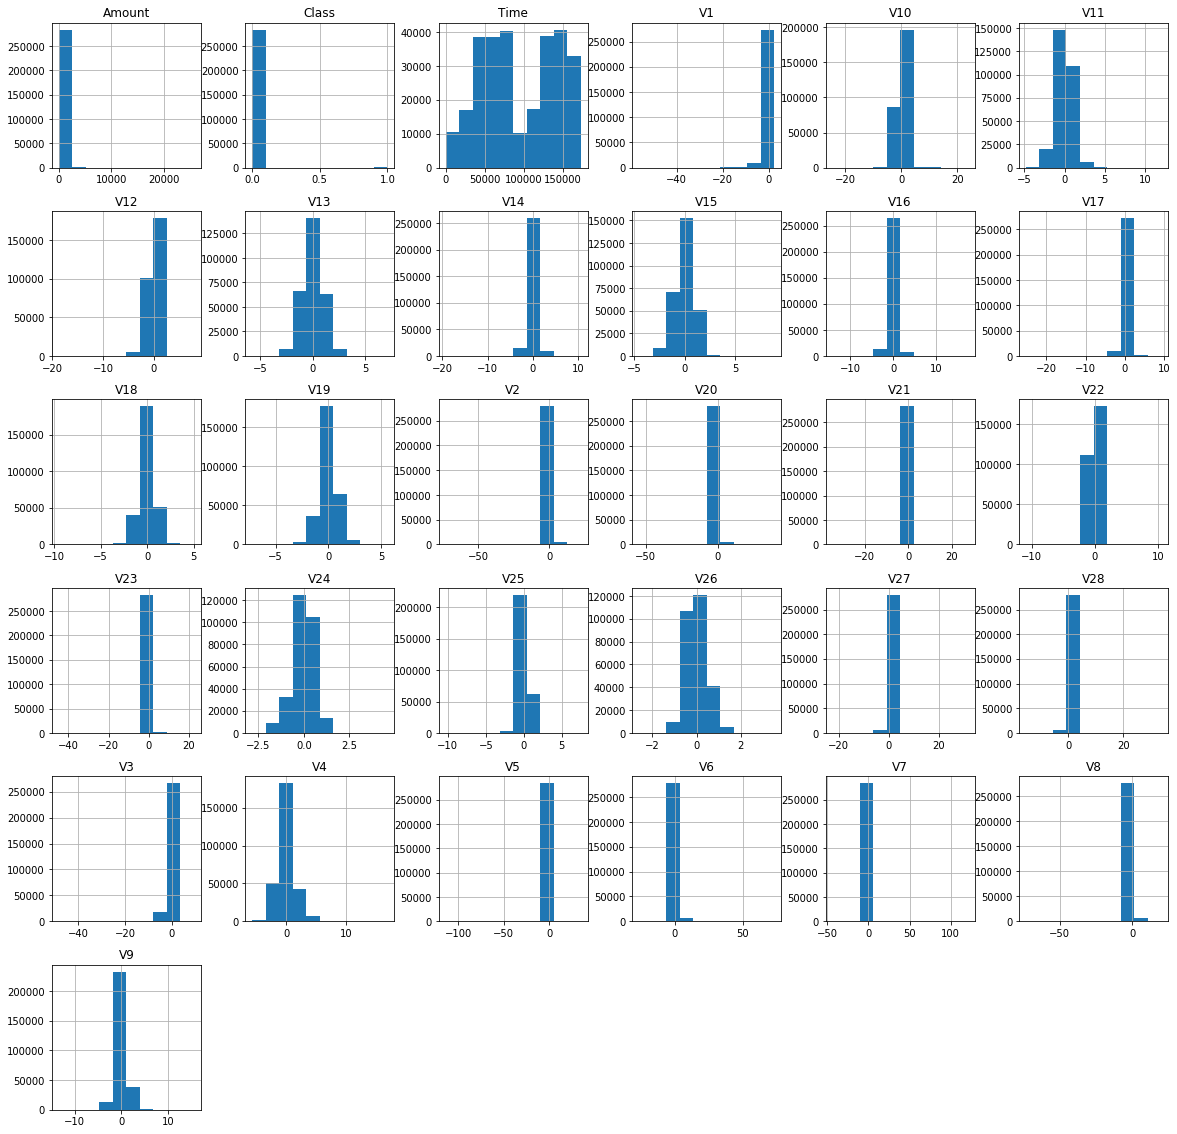

In [173]:
#Histogram
df.hist(figsize=(20,20))
plt.show()

In [174]:
fraud = df[df['Class']==1]
valid = df[df['Class']==0]

In [175]:
outlier_fraction = len(fraud)/float(len(valid))
print(outlier_fraction)

0.0017304750013189597


In [176]:
print(f'Fraud Cases: {len(fraud)}')
print(f'Valid Cases: {len(valid)}')

Fraud Cases: 492
Valid Cases: 284315


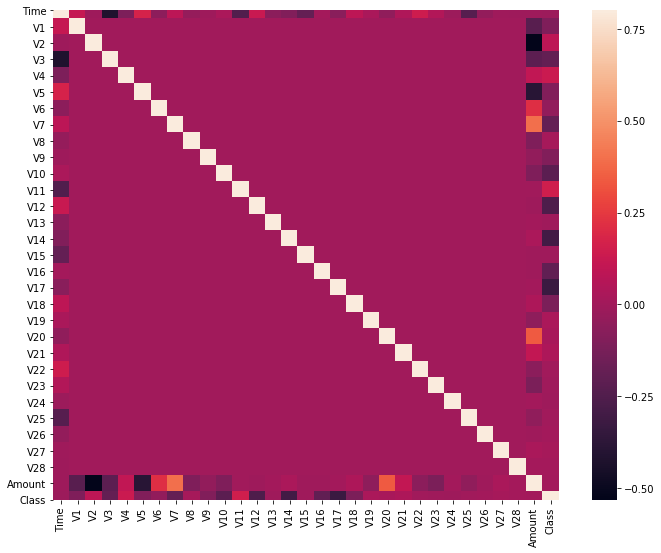

In [177]:
#correlation matrix
corrmat= df.corr()
fig = plt.figure(figsize=(12,9))

sns.heatmap(corrmat,vmax=.8, square = True)
plt.show()

In [178]:
# get all columns from df
cols = list(df.columns)

In [179]:
#filter class from columns
cols.remove('Class')

In [180]:
X = df[cols]
y = df['Class']

In [181]:
X.shape

(284807, 30)

In [182]:
y.shape

(284807,)

In [187]:
list(df.columns)

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [195]:
dffraud = df[['Time','Amount','Class']]

In [198]:
df[['Time','Amount','Class']].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


In [200]:
dffraud[dffraud['Class']==0].describe()

,Time,Amount,Class
count,284315.000000,284315.000000,284315.0
mean,94838.202258,88.291022,0.0
std,47484.015786,250.105092,0.0
min,0.000000,0.000000,0.0
25%,54230.000000,5.650000,0.0
50%,84711.000000,22.000000,0.0
75%,139333.000000,77.050000,0.0
max,172792.000000,25691.160000,0.0


In [199]:
dffraud[dffraud['Class']==1].describe()

,Time,Amount,Class
count,492.000000,492.000000,492.0
mean,80746.806911,122.211321,1.0
std,47835.365138,256.683288,0.0
min,406.000000,0.000000,1.0
25%,41241.500000,1.000000,1.0
50%,75568.500000,9.250000,1.0
75%,128483.000000,105.890000,1.0
max,170348.000000,2125.870000,1.0


In [201]:
dffraud[dffraud['Class']==1]

,Time,Amount,Class
541,406.0,0.00,1
623,472.0,529.00,1
4920,4462.0,239.93,1
6108,6986.0,59.00,1
6329,7519.0,1.00,1
...,...,...,...
279863,169142.0,390.00,1
280143,169347.0,0.76,1
280149,169351.0,77.89,1
281144,169966.0,245.00,1


In [204]:
dffraud[dffraud['Class']==0]

,Time,Amount,Class
0,0.0,149.62,0
1,0.0,2.69,0
2,1.0,378.66,0
3,1.0,123.50,0
4,2.0,69.99,0
...,...,...,...
284802,172786.0,0.77,0
284803,172787.0,24.79,0
284804,172788.0,67.88,0
284805,172788.0,10.00,0


In [206]:
# Portion that is not fraud
df['Class'].value_counts()[0]/len(df)

0.9982725143693799

In [207]:
# Portion that is fraud
df['Class'].value_counts()[1]/len(df)

0.001727485630620034

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

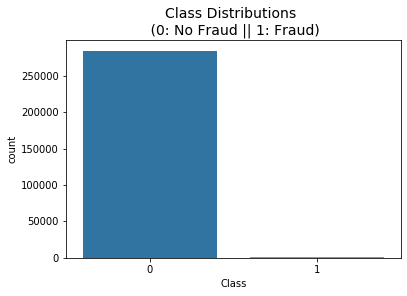

In [209]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Text(0.5, 1.0, 'Distribution of Transaction Time')

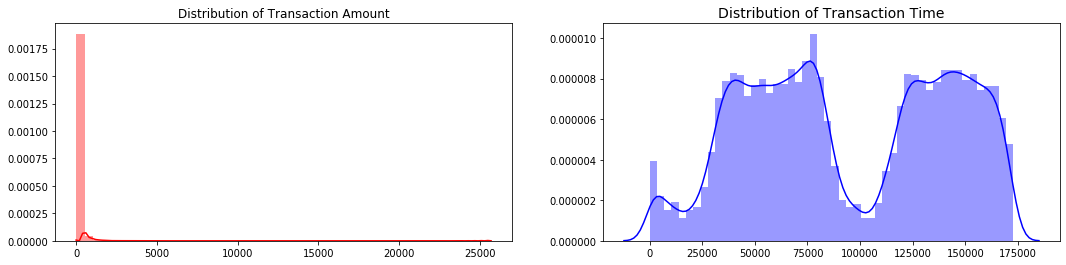

In [216]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.distplot(df['Amount'].values, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount')

sns.distplot(df['Time'].values, ax = ax[1], color = 'b')
ax[1].set_title('Distribution of Transaction Time', fontsize = 14)

In [186]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Start Modeling

In [48]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor

In [71]:
from sklearn.model_selection import train_test_split

In [185]:
X = df[cols]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X Train: {len(X_train)} \nX Test:{len(X_test)}\nY Train:{len(y_train)}\nY Test: {len(y_test)}")

X Train: 199364 
X Test:85443
Y Train:199364
Y Test: 85443


In [73]:
state= 1

In [74]:
#we can also change n_neighbors to see how different it would look

In [76]:
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X_train),
                                       contamination = outlier_fraction,
                                       random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
    n_neighbors= 20,
    contamination = outlier_fraction)
}

In [80]:
# fit model
n_outliers = len(fraud)

for i,(clf_name, clf) in enumerate(classifiers.items()):
    print(i,(clf_name, clf))
    #fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_train)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X_train)
        scores_pred = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
        
    #reshape the prediction: 0 for valid, 1 for fraud
    y_pred[y_pred==1] = 0
    y_pred[y_pred==-1] = 1
    
    n_errors = (y_pred != y_train).sum()
    
    print(f"{clf_name}: {n_errors}")
    print(accuracy_score(y_train,y_pred))
    print(classification_report(y_train,y_pred))
    
    

0 ('Isolation Forest', IsolationForest(behaviour='old', bootstrap=False,
                contamination=0.0017304750013189597, max_features=1.0,
                max_samples=190820, n_estimators=100, n_jobs=None,
                random_state=1, verbose=0, warm_start=False))


/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 468
0.9975474268944555
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190477
           1       0.31      0.30      0.31       343

    accuracy                           1.00    190820
   macro avg       0.65      0.65      0.65    190820
weighted avg       1.00      1.00      1.00    190820

1 ('Local Outlier Factor', LocalOutlierFactor(algorithm='auto', contamination=0.0017304750013189597,
                   leaf_size=30, metric='minkowski', metric_params=None,
                   n_jobs=None, n_neighbors=20, novelty=False, p=2))
Local Outlier Factor: 656
0.9965622052195786
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190477
           1       0.03      0.03      0.03       343

    accuracy                           1.00    190820
   macro avg       0.51      0.51      0.51    190820
weighted avg       1.00      1.00      1.00    190820



## XGB

In [146]:
import xgboost as xgb

In [157]:
X = df[cols]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"X Train: {len(X_train)}, X Test:{len(X_test)}, Y Train:{len(y_train)}, Y Test: {len(y_test)}")

X Train: 190820, X Test:93987, Y Train:190820, Y Test: 93987


In [158]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 99.97%
Validation accuracy: 99.96%


In [159]:
print(accuracy_score(y_train,training_preds))
print(classification_report(y_train,training_preds))

0.999664605387276
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190477
           1       0.98      0.83      0.90       343

    accuracy                           1.00    190820
   macro avg       0.99      0.92      0.95    190820
weighted avg       1.00      1.00      1.00    190820



In [160]:
print(accuracy_score(y_test,val_preds))
print(classification_report(y_test,val_preds))

0.999627608073457
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.93      0.83      0.88       149

    accuracy                           1.00     93987
   macro avg       0.97      0.91      0.94     93987
weighted avg       1.00      1.00      1.00     93987



# Cross Validation

In [168]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [169]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
#testing models
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(model, X_test, y_test, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

LR: 0.999085 (0.000298)
LDA: 0.999308 (0.000112)
KNN: 0.998468 (0.000244)
CART: 0.999223 (0.000099)


/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/johnrick/opt/anaconda3/lib/

SVM: 0.998457 (0.000254)
XGB: 0.998989 (0.000418)


/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/johnrick/

RF: 0.999468 (0.000117)


In [134]:
clf = IsolationForest(max_samples=len(X_train),
                contamination = outlier_fraction,
                random_state=10)

In [135]:
clf.fit(X_train,y_train)

/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False,
                contamination=0.0017304750013189597, max_features=1.0,
                max_samples=190820, n_estimators=100, n_jobs=None,
                random_state=10, verbose=0, warm_start=False)

In [136]:
y_pred = clf.predict(X_train)

/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [137]:
val_preds= clf.predict(X_test)

/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [138]:
training_accuracy=accuracy_score(y_train, y_pred)

In [139]:
val_accuracy = accuracy_score(y_test, val_preds)

In [140]:
training_accuracy

0.0013206162876008803

In [141]:
val_accuracy

0.0010214178556608893

In [142]:
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 0.1321%
Validation accuracy: 0.1021%


In [143]:
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1

In [144]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190477
           1       0.27      0.27      0.27       343

    accuracy                           1.00    190820
   macro avg       0.64      0.63      0.63    190820
weighted avg       1.00      1.00      1.00    190820



In [111]:
#Local Outlier Factor
y_pred = clf0.fit_predict(X_train)
scores_pred = clf0.negative_outlier_factor_




In [112]:
len(y_pred)

190820

In [114]:
len(y_train)

190820

In [116]:
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1

In [118]:
n_errors = (y_pred != y_train).sum()

In [120]:
n_errors

656

In [121]:
print(f"Local Outlier Factor: {n_errors}")
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Local Outlier Factor: 656


ValueError: Found input variables with inconsistent numbers of samples: [93987, 190820]

In [12]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227845, 30)
(56962, 30)
(227845,)
(56962,)


In [17]:
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

0    227450
1       395
Name: Class, dtype: int64
0    0.998266
1    0.001734
Name: Class, dtype: float64
0    56865
1       97
Name: Class, dtype: int64
0    0.998297
1    0.001703
Name: Class, dtype: float64


In [18]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)

In [19]:
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

In [20]:
parameters = {'num_leaves': 2**8,
              'learning_rate': 0.1,
              'is_unbalance': True,
              'min_split_gain': 0.1,
              'min_child_weight': 1,
              'reg_lambda': 1,
              'subsample': 1,
              'objective':'binary',
              #'device': 'gpu', # comment this line if you are not using GPU
              'task': 'train'
              }
num_rounds = 300

In [36]:
%%time
clf = lgb.train(parameters, lgb_train, num_boost_round=num_rounds)

CPU times: user 51.8 s, sys: 723 ms, total: 52.5 s
Wall time: 4.72 s


In [37]:
y_prob = clf.predict(X_test)

In [52]:
y_pred = binarize_prediction(y_prob, threshold=0.5)

In [66]:
def classification_metrics_binary(y_true, y_pred):
    """Returns a report with different metrics for a binary classification problem.
    - Accuracy: Number of correct predictions made as a ratio of all predictions. Useful when there are equal number
    of observations in each class and all predictions and prediction errors are equally important.
    - Confusion matrix: C_ij where observations are known to be in group i but predicted to be in group j. In binary
    classification true negatives is C_00, false negatives is C_10, true positives is C_11 and false positives is C_01.
    - Precision: Number of true positives divided by the number of true and false positives. It is the ability of the
    classifier not to label as positive a sample that is negative.
    - Recall: Number of true positives divided by the number of true positives and false negatives. It is the ability
    of the classifier to find all the positive samples.
    High Precision and low Recall will return few positive results but most of them will be correct. 
    High Recall and low Precision will return many positive results but most of them will be incorrect.
    - F1 Score: 2*((precision*recall)/(precision+recall)). It measures the balance between precision and recall.
    Args:
        y_true (list or np.array): True labels.
        y_pred (list or np.array): Predicted labels (binary).
    Returns:
        report (dict): Dictionary with metrics.
    Examples:
        >>> from collections import OrderedDict
        >>> y_true = [0,1,0,0,1]
        >>> y_pred = [0,1,0,1,1]
        >>> result = classification_metrics_binary(y_true, y_pred)
        >>> OrderedDict(sorted(result.items()))
        OrderedDict([('Accuracy', 0.8), ('Confusion Matrix', array([[2, 1],
               [0, 2]])), ('F1', 0.8), ('Precision', 0.6666666666666666), ('Recall', 1.0)])
    """
    m_acc = accuracy_score(y_true, y_pred)
    m_f1 = f1_score(y_true, y_pred)
    m_precision = precision_score(y_true, y_pred)
    m_recall = recall_score(y_true, y_pred)
    m_conf = confusion_matrix(y_true, y_pred)
    report = {'Accuracy': m_acc, 'Precision': m_precision,
              'Recall': m_recall, 'F1': m_f1, 'Confusion Matrix': m_conf}
    return report


def classification_metrics_binary_prob(y_true, y_prob):
    """Returns a report with different metrics for a binary classification problem.
    - AUC: The Area Under the Curve represents the ability to discriminate between positive and negative classes. An
    area of 1 represent perfect scoring and an area of 0.5 means random guessing.
    - Log loss: Also called logistic regression loss or cross-entropy loss. It quantifies the performance by
    penalizing false classifications. Minimizing the Log Loss is equivalent to minimizing the squared error but using
    probabilistic predictions. Log loss penalize heavily classifiers that are confident about incorrect classifications.
    Args:
        y_true (list or np.array): True labels.
        y_prob (list or np.array): Predicted labels (probability).
    Returns:
        report (dict): Dictionary with metrics.
    Examples:
        >>> from collections import OrderedDict
        >>> y_true = [0,1,0,0,1]
        >>> y_prob = [0.2,0.7,0.4,0.3,0.2]
        >>> result = classification_metrics_binary_prob(y_true, y_prob)
        >>> OrderedDict(sorted(result.items()))
        OrderedDict([('AUC', 0.5833333333333333), ('Log loss', 0.6113513950783531)])
        >>> y_prob = [0.2,0.7,0.4,0.3,0.3]
        >>> result = classification_metrics_binary_prob(y_true, y_prob)
        >>> OrderedDict(sorted(result.items()))
        OrderedDict([('AUC', 0.75), ('Log loss', 0.5302583734567203)])
    """
    m_auc = roc_auc_score(y_true, y_prob)
    m_logloss = log_loss(y_true, y_prob)
    report = {'AUC': m_auc, 'Log loss': m_logloss}
    return report


def binarize_prediction(y, threshold=0.5):
    """Binarize prediction based on a threshold
    Args:
        y (np.array): Array with predictions.
        threshold (float): Theshold value for binarization.
    """
    y_pred = np.where(y > threshold, 1, 0)
    return y_pred


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Args:
        cm (np.array): The confusion matrix array.
        classes (list): List wit the classes names.
        normalize (bool): Flag to normalize data.
        title (str): Title of the plot.
        cmap (matplotlib.cm): Matplotlib colormap https://matplotlib.org/api/cm_api.html
    Examples:
        >>> import numpy as np
        >>> a = np.array([[10, 3, 0],[1, 2, 3],[1, 5, 9]])
        >>> classes = ['cl1', 'cl2', 'cl3']
        >>> plot_confusion_matrix(a, classes, normalize=False)
        >>> plot_confusion_matrix(a, classes, normalize=True)
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0:
        cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def chunked_http_client(num_chunks, s):
    # Use semaphore to limit number of requests
    semaphore = asyncio.Semaphore(num_chunks)

    @asyncio.coroutine
    # Return co-routine that will work asynchronously and respect locking of semaphore
    def http_get(url, payload, verbose):
        nonlocal semaphore
        with (yield from semaphore):
            headers = {'content-type': 'application/json'}
            response = yield from s.request('post', url, data=json.dumps(payload), headers=headers)
            if verbose:
                print("Response status:", response.status)
            body = yield from response.json()
            if verbose:
                print(body)
            yield from response.wait_for_close()
        return body
    return http_get


def run_load_test(url, payloads, _session, concurrent, verbose):
    http_client = chunked_http_client(num_chunks=concurrent, s=_session)

    # http_client returns futures, save all the futures to a list
    tasks = [http_client(url, payload, verbose) for payload in payloads]

    dfs_route = []
    # wait for futures to be ready then iterate over them
    for future in asyncio.as_completed(tasks):
        data = yield from future
        try:
            dfs_route.append(data)
        except Exception as err:
            print("Error {0}".format(err))
    return dfs_route

In [61]:
import matplotlib.pyplot as plt

In [74]:
metrics  =  classification_metrics_binary(y_test, y_pred)
metrics2 = classification_metrics_binary_prob(y_test, y_prob)
metrics.update(metrics2)
cm = metrics['Confusion Matrix']
metrics.pop('Confusion Matrix', None)

array([[55857,  1008],
       [   11,    86]])

{
   "AUC": 0.9415950782328557,
   "Accuracy": 0.9821108809381693,
   "F1": 0.14441645675902604,
   "Log loss": 0.5933828498237144,
   "Precision": 0.07861060329067641,
   "Recall": 0.8865979381443299
}


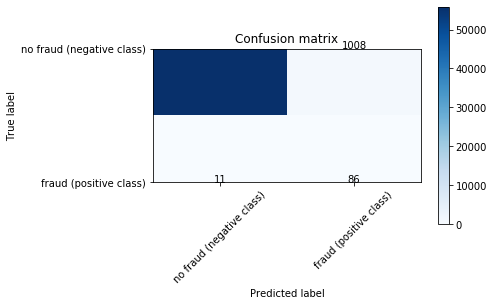

In [75]:
print(json.dumps(metrics, indent=3, sort_keys=True))
plot_confusion_matrix(cm, ['no fraud (negative class)', 'fraud (positive class)'])

In [ ]:
def binarize_prediction(y, threshold=0.5):
    """Binarize prediction based on a threshold
    Args:
        y (np.array): Array with predictions.
        threshold (float): Theshold value for binarization.
    """
    y_pred = np.where(y > threshold, 1, 0)
    return y_pred

# Create Pipeline

In [77]:
from sklearn.pipeline import Pipeline

In [ ]:
aa